In [2]:
import os

try:
    from common.sagemaker_env import LABELBOX_API_KEY
except: 
    LABELBOX_API_KEY = os.environ['LABELBOX_API_KEY']
    
    
CLOUD_PROJECT_ID = "cleamnf3q398707ug5s2z4rp6"

In [6]:

labelbox_dir = "./data/labelbox"
clouds_dir = f'{labelbox_dir}/clouds'
source_dir = f'{clouds_dir}/source'
training_dir = f'{clouds_dir}/training'
labels_dir = f'{training_dir}/labels'
rgb_dir = f'{clouds_dir}/rgb'


In [3]:

def is_island(target_polygon, polygon_list):
    for curr_poly in polygon_list:
        if target_polygon.within(curr_poly):
            return True
        
    return False


## OLD - use parallel version

In [30]:
%reload_ext autoreload
%autoreload 2

import glob
import numpy as np
from patchify import patchify
import rasterio


from common.constants import NODATA_BYTE, NODATA_FLOAT32
import common.utilities.imagery as imagery
import common.utilities.visualization as visualization


import matplotlib.pyplot as plt

raise

PATCH_SIZE = 512

scene_dirs = glob.glob(f'./data/20*/S2*')

for i, scene_dir in enumerate(scene_dirs):
    
    scene = scene_dir.split('/')[-1]
    print(scene)
    
    if "QU" not in scene:
        continue
    
    with rasterio.open(f'{scene_dir}/B08.tif') as src:
        if src.width < 512 or src.height < 512:
            continue
    
    stack_data = []
    transform = None
    tif_paths = sorted(glob.glob(f'{scene_dir}/B*.tif'))
    for path in tif_paths:
        with rasterio.open(path) as src:
            transform = src.transform
            stack_data.append(src.read(1))
            
    stack_data = np.ma.array(stack_data)
    stack_data = imagery.normalize_3d_array(stack_data).transpose((1, 2, 0))
        
    source_patches = patchify(stack_data, (PATCH_SIZE, PATCH_SIZE, stack_data.shape[2]), step=PATCH_SIZE)
    
    for irow in range(source_patches.shape[0]):
        for icol in range(source_patches.shape[1]):
            source_data = source_patches[irow, icol, 0, :, :, :]            
            source_data = np.ma.array(source_data, mask=(source_data==NODATA_FLOAT32))
            
            if source_data.mask.sum() > 0:
                print('skipping:', irow, icol)
                continue
                
            if irow < 4 or icol < 7:
                continue

            rgb_data = source_data[:, :, [2, 1, 0]]
            # rgb_data_norm = np.round(np.multiply(rgb_data, 254)).astype(int)       
            rgb_data_norm = (rgb_data * 254).astype(np.uint8)
            print(np.max(rgb_data_norm))
            continue
            
            print('\t', np.min(rgb_data_norm), np.median(rgb_data_norm), np.max(rgb_data_norm))
            
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 12))
            visualization.plot_bands(rgb_data, ax=ax1, bands=[0, 1, 2], transpose=False)
            visualization.plot_bands(rgb_data_norm, ax=ax2, bands=[0, 1, 2], transpose=False)
            raise
            
            source_path = f'{source_dir}/{scene}_{irow}_{icol}.tif'
            rgb_path = f'{rgb_dir}/{scene}_{irow}_{icol}.tif'
                    
            x_min, y_min = rasterio.transform.xy(transform, PATCH_SIZE*(irow+1), PATCH_SIZE*icol)
            x_max, y_max = rasterio.transform.xy(transform, PATCH_SIZE*irow, PATCH_SIZE*(icol+1))             
            bbox = [x_min, y_min, x_max, y_max]
            
            imagery.write_array_to_tif(rgb_data_norm, rgb_path, bbox, dtype=np.uint8, nodata=255, is_cog=True) 
            imagery.write_array_to_tif(source_data, source_path, bbox, dtype=np.float32, nodata=NODATA_FLOAT32) 
                   

RuntimeError: No active exception to reraise

## Create scene patches in parallel

In [31]:
%reload_ext autoreload
%autoreload 2

import glob
import multiprocessing
import numpy as np
from patchify import patchify
import rasterio


from common.constants import NODATA_BYTE, NODATA_FLOAT32
import common.utilities.imagery as imagery
import common.utilities.visualization as visualization



PATCH_SIZE = 512


def process_scene(scene_dir):
    
    scene = scene_dir.split('/')[-1]
    
    with rasterio.open(f'{scene_dir}/B08.tif') as src:
        if src.width < 512 or src.height < 512:
            return

    stack_data = []
    transform = None
    tif_paths = sorted(glob.glob(f'{scene_dir}/B*.tif'))
    for path in tif_paths:
        with rasterio.open(path) as src:
            transform = src.transform
            stack_data.append(src.read(1))

    stack_data = np.ma.array(stack_data)
    stack_data = imagery.normalize_3d_array(stack_data).transpose((1, 2, 0))
        
    source_patches = patchify(stack_data, (PATCH_SIZE, PATCH_SIZE, stack_data.shape[2]), step=PATCH_SIZE)
    
    for irow in range(source_patches.shape[0]):
        for icol in range(source_patches.shape[1]):
            source_data = source_patches[irow, icol, 0, :, :, :]            
            source_data = np.ma.array(source_data, mask=(source_data==NODATA_FLOAT32))
            
            if source_data.mask.sum() > 0:
                print('skipping:', irow, icol)
                continue
            
            rgb_data = source_data[:, :, [2, 1, 0]]
            rgb_data_norm = (rgb_data * 254).astype(np.uint8)
            rgb_data_norm[rgb_data_norm > 254] = 254
                       
            source_path = f'{source_dir}/{scene}_{irow}_{icol}.tif'
            rgb_path = f'{rgb_dir}/{scene}_{irow}_{icol}.tif'
                    
            x_min, y_min = rasterio.transform.xy(transform, PATCH_SIZE*(irow+1), PATCH_SIZE*icol)
            x_max, y_max = rasterio.transform.xy(transform, PATCH_SIZE*irow, PATCH_SIZE*(icol+1))             
            bbox = [x_min, y_min, x_max, y_max]
            
            imagery.write_array_to_tif(rgb_data_norm, rgb_path, bbox, dtype=np.uint8, nodata=255, is_cog=True) 
            imagery.write_array_to_tif(source_data, source_path, bbox, dtype=np.float32, nodata=NODATA_FLOAT32) 
                       
            
scene_dirs = glob.glob(f'./data/20*/S2*')
print(f'{len(scene_dirs)} scenes')
with multiprocessing.Pool(processes=multiprocessing.cpu_count()) as pool:
    patches = pool.map(process_scene, scene_dirs)
    

103 scenes


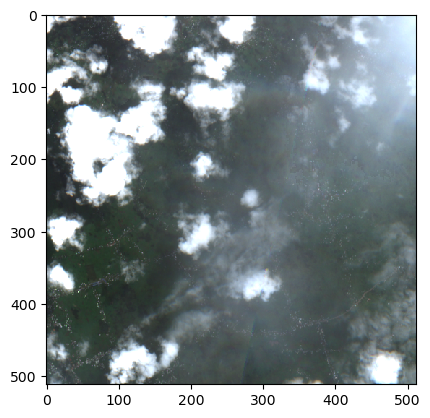

In [32]:
path = "./data/labelbox/clouds/source/S2B_35MQU_20220527_0_L2A_5_7.tif"

with rasterio.open(path) as src:
    data = src.read()
    visualization.plot_bands(data, bands=[2, 1, 0], transpose=True)

In [21]:
%%bash

# gdalinfo -stats ./data/labelbox/clouds/source/S2A_35MQV_20200731_0_L2A_0_0.tif


## Upload to S3

In [33]:
%reload_ext autoreload
%autoreload 2

import common.constants as constants
import common.aws.s3 as s3_utils


def save_patch_to_s3(tif_path):
    
    file_name = tif_path.split('/')[-1]    
    object_key = f'clouds/{file_name}'
    href = f'https://data.smartcarte.earth/{object_key}'
    # print(f'uploading {tif_path} to s3://{constants.S3_DATA_BUCKET}/{object_key}')
    s3_utils.put_item(tif_path, constants.S3_DATA_BUCKET, object_key)
    
    return href


In [34]:
import glob
import shelve



state_path = "./data/trainCloudsState"
with shelve.open(state_path) as state:

    rgb_paths = glob.glob(f'{rgb_dir}/*.tif')
    rgb_paths = [path for path in rgb_paths if not path.endswith("deg.tif")]

    for i, path in enumerate(rgb_paths):
        
        if i % 200 == 0:
            print(f'{i} done')
            
        job_name = path.split('/')[-1].replace('.tif', '')
        s3_href = save_patch_to_s3(path)
        state[job_name] = {
            'rgb_cog_href': s3_href
        }
    

0 done
200 done
400 done
600 done
800 done
1000 done
1200 done
1400 done
1600 done
1800 done
2000 done
2200 done
2400 done
2600 done
2800 done
3000 done
3200 done
3400 done
3600 done


## Create dataset in Labelbox

In [36]:
import datetime
import glob
import json
from labelbox import Client, Dataset, DataRow
import os
import random
import shelve
from uuid import uuid4


client = Client(api_key=LABELBOX_API_KEY)
project = client.get_project(CLOUD_PROJECT_ID)

today = datetime.datetime.today().strftime('%Y%m%d')

clouds_dataset_name = f"{today} Clouds"

clouds_dataset = client.get_datasets(where=(Dataset.name==clouds_dataset_name)).get_one()
if clouds_dataset is None:
    clouds_dataset = client.create_dataset(name=clouds_dataset_name)
else:
    raise ValueError("today's clouds dataset already exists")

    
payload = []
with shelve.open(state_path) as state:
    for job_name in state.keys():        
        row = {
            "min_zoom": 12,
            "max_zoom": 14,
            "tile_layer_url": state[job_name]["rgb_cog_href"]
        }
        
        payload.append(row)


payload = [{DataRow.row_data: row} for row in payload]

random.seed(666)
random.shuffle(payload)

start_idx, end_idx = 0, 1000
payload = payload[start_idx:end_idx]

print(f'{len(payload)} data rows')
task = clouds_dataset.create_data_rows(payload)
task.wait_till_done()

print('done')

1000 data rows
done


In [ ]:
files = glob.glob("./data/labelbox/clouds/source/*.tif")
print(len(files))

664


## Pull data from Labelbox

In [7]:
from datetime import datetime, timedelta
from labelbox import Client


def get_data_rows():
    client = Client(api_key=LABELBOX_API_KEY)
    project = client.get_project(CLOUD_PROJECT_ID)

    now = datetime.today()
    then = now - timedelta(days=60)

    data_rows = project.export_labels(download=True) #, start=then.strftime('%Y-%m-%d'), end=now.strftime('%Y-%m-%d'))    
    return data_rows


def is_island(target_polygon, polygon_list):
    for curr_poly in polygon_list:
        if target_polygon.within(curr_poly):
            return True
        
    return False


69 done data rows
done


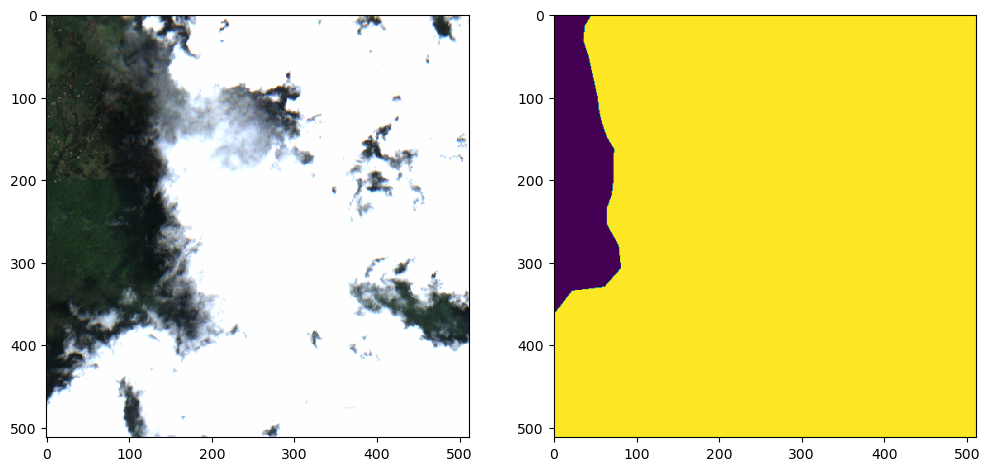

In [10]:
import json
import matplotlib.pyplot as plt
import numpy as np
import rasterio
from rasterio.features import geometry_mask
from shapely.geometry import Polygon


from common.utilities.imagery import write_array_to_tif
from common.utilities.visualization import plot_bands


CLOUD_CLASSES = {
    'no_cloud': 0,
    'cloud': 1
}

data_rows = get_data_rows()    
data_rows = [dr for dr in data_rows if dr['DataRow Workflow Info']['taskName'] == "Done"]
print(f'{len(data_rows)} done data rows')

for i, row in enumerate(data_rows):
        
    row_id = row['DataRow ID']
    labels = row['Label']['objects']
    metadata = json.loads(row['Labeled Data'])
    rgb_cog_url = metadata['tileLayerUrl']
    job_name = rgb_cog_url.split('/')[-1].replace('.tif', '')
    
    rgb_path = f'{rgb_dir}/{job_name}.tif'
    composite_path = f'{source_dir}/{job_name}.tif'
    label_path = f'{labels_dir}/{job_name}.tif'

    with rasterio.open(composite_path) as src:
        bbox = list(src.bounds)
        composite_shape = src.shape
        composite_transform = src.transform
    
    label_polygons = {
        label['featureId']: Polygon(label['geometry']['coordinates'][0])
        for label in labels
    }
        
    # 0: no_cloud, 1: cloud
    labels_data = np.zeros(composite_shape).astype(np.uint8)
    
    islands = []    
    sorted_labels = sorted(labels, key=lambda lab: lab['value'], reverse=True)   
    for label in sorted_labels:
        class_value = label['value']
        class_idx = CLOUD_CLASSES[class_value]
                
        label_id = label['featureId']
        polygon = label_polygons[label_id]
        polygon_mask = geometry_mask([polygon], composite_shape, composite_transform, invert=True)
        
        test_polygons = label_polygons.copy()
        del test_polygons[label_id]
        is_poly_island = is_island(polygon, list(test_polygons.values()))
                
        if is_poly_island:
            islands.append((class_idx, polygon_mask))
        else:
            labels_data[polygon_mask] = class_idx

    
    for class_idx, polygon_mask in islands:
        labels_data[polygon_mask] = class_idx
          
    write_array_to_tif(labels_data, label_path, bbox, dtype=np.uint8, nodata=255)

    # plot
    if i == 53:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 12))
        with rasterio.open(rgb_path) as src:
            data = src.read()
            plot_bands(data, ax=ax1, bands=[0, 1, 2], transpose=True)

        ax2.imshow(labels_data, vmin=0, vmax=1)
       
        
print('done')

## Data augmentation - rotate images

In [11]:
%reload_ext autoreload
%autoreload 2

import glob
import matplotlib.pyplot as plt
import numpy as np
import rasterio

from common.constants import NODATA_BYTE, NODATA_FLOAT32
import common.utilities.imagery as imagery
import common.utilities.visualization as visualization


label_paths = glob.glob(f'{labels_dir}/S2*[0-9].tif')


for label_path in label_paths:
    rgb_path = label_path.replace(labels_dir, rgb_dir)
    source_path = label_path.replace(labels_dir, source_dir)
        
    with rasterio.open(source_path) as source_src:
        source_data = source_src.read()
        bbox = list(source_src.bounds)
        
    with rasterio.open(rgb_path) as rgb_src:
        rgb_data = rgb_src.read()
        
    with rasterio.open(label_path) as label_src:
        label_data = label_src.read(1)
          
    # copy source and rgb tiffs to training subdirectory
    rgb_target_path = label_path.replace('/labels/', '/rgb/')
    source_target_path = label_path.replace('/labels/', '/source/')

    imagery.write_array_to_tif(rgb_data.transpose((1, 2, 0)), rgb_target_path, bbox, dtype=np.float32, nodata=NODATA_FLOAT32)
    imagery.write_array_to_tif(source_data.transpose((1, 2, 0)), source_target_path, bbox, dtype=np.float32, nodata=NODATA_FLOAT32)
                    
    for i in range(1, 4):
        
        source_rotated = np.rot90(source_data, k=i, axes=(1, 2))
        source_rotated = source_rotated.transpose((1, 2, 0))
        
        rgb_rotated = np.rot90(rgb_data, k=i, axes=(1, 2))
        rgb_rotated = rgb_rotated.transpose((1, 2, 0))
        
        label_rotated = np.rot90(label_data, k=i, axes=(0, 1))
        
        source_rotated_path = source_target_path.replace('.tif', f'_{i*90}deg.tif')
        rgb_rotated_path = rgb_target_path.replace('.tif', f'_{i*90}deg.tif')
        label_rotated_path = label_path.replace('.tif', f'_{i*90}deg.tif')
                
        imagery.write_array_to_tif(source_rotated, source_rotated_path, bbox, dtype=np.float32, nodata=NODATA_FLOAT32)
        imagery.write_array_to_tif(rgb_rotated, rgb_rotated_path, bbox, dtype=np.float32, nodata=NODATA_FLOAT32)
        imagery.write_array_to_tif(label_rotated, label_rotated_path, bbox, dtype=np.uint8, nodata=NODATA_BYTE)
        
        #fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 12))
        #plot_bands(rgb_data, ax=ax1, bands=[0, 1, 2], transpose=True)
        #plot_bands(rgb_rotated, ax=ax2, bands=[0, 1, 2], transpose=False)
        #ax1.imshow(label_data, vmin=0, vmax=1)
        #ax2.imshow(label_rotated, vmin=0, vmax=1)      
        
print('done')

## Create train and val folders

In [ ]:
import os
import shutil
import splitfolders


output_dir = "./data/trainingCloudData"
"""
if os.path.exists(output_dir):
    shutil.rmtree(output_dir)

    
splitfolders.ratio(training_dir, output=output_dir, seed=314, ratio=(.85, .15), group_prefix=None);
"""
print('done')

## Merge Labelbox and Radiant Earth datasets

In [12]:

merged_original_dir = "./data/mergedCloudTrainingData/original"
merged_split_dir = "./data/mergedCloudTrainingData/split"
re_cloud_dir = "./data/radiantEarth/clouds"
labelbox_cloud_dir = "./data/labelbox/clouds/training"


In [13]:
import glob
import multiprocessing
import os
import shutil



os.makedirs(f'{merged_original_dir}/source', exist_ok=True)
os.makedirs(f'{merged_original_dir}/labels', exist_ok=True)
os.makedirs(merged_split_dir, exist_ok=True)


def process_label_path(path):
    file_name = path.split('/')[-1]
    dst_path = f'{merged_original_dir}/labels/{file_name}'
    shutil.copy2(path, dst_path)

    
def process_source_path(path):
    file_name = path.split('/')[-1]
    dst_path = f'{merged_original_dir}/source/{file_name}'
    shutil.copy2(path, dst_path)

    
all_cloud_dirs = [labelbox_cloud_dir, re_cloud_dir]    
for _dir in all_cloud_dirs:
    print(_dir)
    
    label_paths = glob.glob(f'{_dir}/labels/*.tif')            
    with multiprocessing.Pool(processes=multiprocessing.cpu_count()) as pool:
        pool.map(process_label_path, label_paths)

    source_paths = [p.replace('/labels/', '/source/') for p in label_paths]
    with multiprocessing.Pool(processes=multiprocessing.cpu_count()) as pool:
        pool.map(process_source_path, source_paths)

print('done')

./data/labelbox/clouds/training
./data/radiantEarth/clouds
done


## Split data into training / val / test

In [14]:
import os
import shutil
import splitfolders


if os.path.exists(merged_split_dir):
    shutil.rmtree(merged_split_dir)

splitfolders.ratio(merged_original_dir, output=merged_split_dir, seed=666, ratio=(0.80, 0.10, 0.10), group_prefix=None);

print('done')

Copying files: 3752 files [03:49, 16.33 files/s]

done
